# Programe sua GPU com OpenMP

Autores:
_Hermes Senger_ e
_Jaime Freire de Souza_

## Configuração do ambiente

Precisaremos de um compilador capaz de gerar código executável para GPUs.


In [15]:
%%shell

ln -sfnv /usr/local/cuda-11/ /usr/local/cuda

pip install matplotlib numpy

wget https://openmp-course.s3.amazonaws.com/llvm.tar.gz

tar -xzvf llvm.tar.gz >/dev/null 2>&1

echo "  ------------  Terminou a instalação! Pode continuar  ------------------"

'/usr/local/cuda' -> '/usr/local/cuda-11/'
--2023-07-16 18:23:05--  https://openmp-course.s3.amazonaws.com/llvm.tar.gz
Resolving openmp-course.s3.amazonaws.com (openmp-course.s3.amazonaws.com)... 3.5.16.172, 16.182.40.81, 54.231.194.233, ...
Connecting to openmp-course.s3.amazonaws.com (openmp-course.s3.amazonaws.com)|3.5.16.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 810538565 (773M) [application/x-gzip]
Saving to: ‘llvm.tar.gz.1’

llvm.tar.gz.1       100%[===================>] 772.99M  58.3MB/s    in 13s     

2023-07-16 18:23:18 (59.0 MB/s) - ‘llvm.tar.gz.1’ saved [810538565/810538565]

  ------------  Terminou a instalação! Pode continuar  ------------------


In [2]:
import os

os.environ['LLVM_PATH'] = '/content/llvm'
os.environ['PATH'] = os.environ['LLVM_PATH'] + '/bin:' + os.environ['PATH']
os.environ['LD_LIBRARY_PATH'] = os.environ['LLVM_PATH'] + '/lib:' + os.environ['LD_LIBRARY_PATH']
os.environ['TSAN_OPTIONS'] = 'ignore_noninstrumented_modules=1'


Vamos testar nosso ambiente de programação.

Vamos verificar o modelo de GPU alocada.

In [3]:
!nvidia-smi

Sun Jul 16 18:15:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------


#  Equação da onda - Versão 0.1 (serial)


Versão serial


In [4]:
%%writefile wave_serial.c

#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <sys/time.h>

#define DT 0.002f // delta t
#define DZ 20.0f // delta z
#define DX 20.0f // delta x
#define V 1500.0f // wave velocity v = 1500 m/s

//save the matrix on a file.txt
void save_grid(size_t nz, size_t nx, double *grid){

    system("mkdir -p wavefield");

    char file_name[32];
    sprintf(file_name, "wavefield/wavefield.txt");

    // save the result
    FILE *file;
    file = fopen(file_name, "w");

    for(size_t i = 1; i < nz - 1; i++) {

        size_t offset = i * nx;

        for(size_t j = 1; j < nx - 1; j++) {
            fprintf(file, "%f ", grid[offset + j]);
        }
        fprintf(file, "\n");
    }

    fclose(file);
}

int main(int argc, char* argv[]) {

    // validate the parameters
    if(argc != 4){
        printf("Usage: ./stencil N1 N2 ITERATIONS\n");
        printf("N1 N2: grid sizes for the stencil\n");
        printf("ITERATIONS: number of timesteps\n");
        exit(-1);
    }

    // number of rows of the grid
    size_t nz = atoi(argv[1]);

    // number of columns of the grid
    size_t nx = atoi(argv[2]);

    // number of timesteps
    size_t iterations = atoi(argv[3]);

    printf("Grid Sizes: %ld x %ld\n", nz, nx);
    printf("Iterations: %ld\n", iterations);

    // add the spatial order (halo zone) to the grid size
    nz += 2;
    nx += 2;

    // represent the matrix of wavefield as an array
    double *prev_u = (double*) malloc(nz * nx * sizeof(double));
    double *next_u = (double*) malloc(nz * nx * sizeof(double));

    // represent the matrix of velocities as an array
    double *vel_model = (double*) malloc(nz * nx * sizeof(double));

    // ************* BEGIN INITIALIZATION *************

    printf("Initializing ... \n");

    // initialize matrix
    for(size_t i = 0; i < nz; i++){

        size_t offset = i * nx;

        for(size_t j = 0; j < nx; j++){
            prev_u[offset + j] = 0.0;
            next_u[offset + j] = 0.0;
            vel_model[offset + j] = V;
        }
    }

    // add a source to initial wavefield as an initial condition
    double val = 1.f;
    for(int s = 4; s >= 0; s--){
        for(size_t i = nz / 2 - s; i < nz / 2 + s; i++){

            size_t offset = i * nx;

            for(size_t j = nx / 2 - s; j < nx / 2 + s; j++)
                prev_u[offset + j] = val;
        }
        val *= 0.9;
    }

    // ************** END INITIALIZATION **************

    printf("Computing wavefield ... \n");

    double dzSquared = DZ * DZ;
    double dxSquared = DX * DX;
    double dtSquared = DT * DT;

    // variable to measure execution time
    struct timeval time_start;
    struct timeval time_end;

    // get the start time
    gettimeofday(&time_start, NULL);

    // wavefield modeling
    for(size_t n = 0; n < iterations; n++) {

        for(size_t i = 1; i < nz - 1; i++) {
            for(size_t j = 1; j < nx - 1; j++) {
                // index of the current point in the grid
                size_t current = i * nx + j;

                //neighbors in the horizontal direction
                double value = (prev_u[current + 1] - 2.0 * prev_u[current] + prev_u[current - 1]) / dxSquared;
                //neighbors in the vertical direction
                value += (prev_u[current + nx] - 2.0 * prev_u[current] + prev_u[current - nx]) / dzSquared;

                value *= dtSquared * vel_model[current] * vel_model[current];
                next_u[current] = 2.0 * prev_u[current] - next_u[current] + value;
            }
        }

        // swap arrays for next iteration
        double *swap = next_u;
        next_u = prev_u;
        prev_u = swap;
    }

    // get the end time
    gettimeofday(&time_end, NULL);

    double exec_time = (double) (time_end.tv_sec - time_start.tv_sec) + (double) (time_end.tv_usec - time_start.tv_usec) / 1000000.0;

    save_grid(nz, nx, next_u);

    printf("Iterations completed in %f seconds \n", exec_time);

    free(prev_u);
    free(next_u);
    free(vel_model);

    return 0;
}

Writing wave_serial.c


In [5]:
%%shell

clang -O3 wave_serial.c -o wave_serial

In [6]:
%%shell

./wave_serial 1024 1024 2000

Grid Sizes: 1024 x 1024
Iterations: 2000
Initializing ... 
Computing wavefield ... 
Iterations completed in 8.258730 seconds 


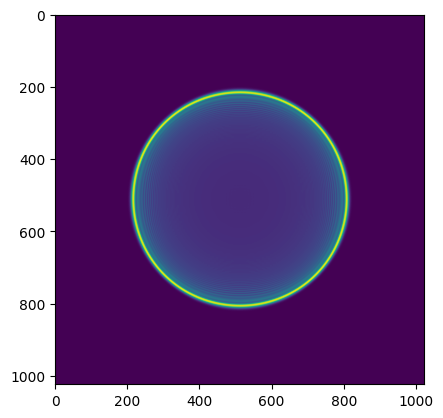

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# read the input (wavefield N x M) file
input = np.loadtxt('wavefield/wavefield.txt')

# process data e generate the plot
plt.imshow(input)
plt.show()


#  Equação da onda - Versão 1 (thread team)


Versão serial


In [8]:
%%writefile wave_gpu.c

#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <sys/time.h>
#include <omp.h>

#define DT 0.002f // delta t
#define DZ 20.0f // delta z
#define DX 20.0f // delta x
#define V 1500.0f // wave velocity v = 1500 m/s

//save the matrix on a file.txt
void save_grid(size_t nz, size_t nx, double *grid){

    system("mkdir -p wavefield");

    char file_name[32];
    sprintf(file_name, "wavefield/wavefield.txt");

    // save the result
    FILE *file;
    file = fopen(file_name, "w");

    for(size_t i = 1; i < nz - 1; i++) {

        size_t offset = i * nx;

        for(size_t j = 1; j < nx - 1; j++) {
            fprintf(file, "%f ", grid[offset + j]);
        }
        fprintf(file, "\n");
    }

    fclose(file);
}

int main(int argc, char* argv[]) {

    // validate the parameters
    if(argc != 4){
        printf("Usage: ./stencil N1 N2 ITERATIONS\n");
        printf("N1 N2: grid sizes for the stencil\n");
        printf("ITERATIONS: number of timesteps\n");
        exit(-1);
    }

    // number of rows of the grid
    size_t nz = atoi(argv[1]);

    // number of columns of the grid
    size_t nx = atoi(argv[2]);

    // number of timesteps
    size_t iterations = atoi(argv[3]);

    printf("Grid Sizes: %ld x %ld\n", nz, nx);
    printf("Iterations: %ld\n", iterations);

    // add the spatial order (halo zone) to the grid size
    nz += 2;
    nx += 2;

    // represent the matrix of wavefield as an array
    double *prev_u = (double*) malloc(nz * nx * sizeof(double));
    double *next_u = (double*) malloc(nz * nx * sizeof(double));

    // represent the matrix of velocities as an array
    double *vel_model = (double*) malloc(nz * nx * sizeof(double));

    // ************* BEGIN INITIALIZATION *************

    printf("Initializing ... \n");

    // initialize matrix
    for(size_t i = 0; i < nz; i++){

        size_t offset = i * nx;

        for(size_t j = 0; j < nx; j++){
            prev_u[offset + j] = 0.0;
            next_u[offset + j] = 0.0;
            vel_model[offset + j] = V;
        }
    }

    // add a source to initial wavefield as an initial condition
    double val = 1.f;
    for(int s = 4; s >= 0; s--){
        for(size_t i = nz / 2 - s; i < nz / 2 + s; i++){

            size_t offset = i * nx;

            for(size_t j = nx / 2 - s; j < nx / 2 + s; j++)
                prev_u[offset + j] = val;
        }
        val *= 0.9;
    }

    // ************** END INITIALIZATION **************

    printf("Computing wavefield ... \n");

    double dzSquared = DZ * DZ;
    double dxSquared = DX * DX;
    double dtSquared = DT * DT;

    // variable to measure execution time
    struct timeval time_start;
    struct timeval time_end;

    // get the start time
    gettimeofday(&time_start, NULL);

    #pragma omp target enter data map(to: prev_u[:(nz * nx)])
    #pragma omp target enter data map(to: next_u[:(nz * nx)])
    #pragma omp target enter data map(to: vel_model[:(nz * nx)])

    // wavefield modeling
    for(size_t n = 0; n < iterations; n++) {

        #pragma omp target teams distribute parallel for collapse(2)
        for(size_t i = 1; i < nz - 1; i++) {
            for(size_t j = 1; j < nx - 1; j++) {
                // index of the current point in the grid
                size_t current = i * nx + j;

                //neighbors in the horizontal direction
                double value = (prev_u[current + 1] - 2.0 * prev_u[current] + prev_u[current - 1]) / dxSquared;
                //neighbors in the vertical direction
                value += (prev_u[current + nx] - 2.0 * prev_u[current] + prev_u[current - nx]) / dzSquared;

                value *= dtSquared * vel_model[current] * vel_model[current];
                next_u[current] = 2.0 * prev_u[current] - next_u[current] + value;
            }
        }

        // swap arrays for next iteration
        double *swap = next_u;
        next_u = prev_u;
        prev_u = swap;
    }

    #pragma omp target exit data map(from: next_u[:(nz * nx)])

    // get the end time
    gettimeofday(&time_end, NULL);

    double exec_time = (double) (time_end.tv_sec - time_start.tv_sec) + (double) (time_end.tv_usec - time_start.tv_usec) / 1000000.0;

    save_grid(nz, nx, next_u);

    printf("Iterations completed in %f seconds \n", exec_time);

    free(prev_u);
    free(next_u);
    free(vel_model);

    return 0;
}

Writing wave_gpu.c


In [17]:
%%shell

clang -O3 -fopenmp -fopenmp-targets=nvptx64-nvidia-cuda -Xopenmp-target -march=sm_75 wave_gpu.c -o wave_gpu

./wave_gpu 1024 1024 2000

clang-13: warning: Unknown CUDA version. cuda.h: CUDA_VERSION=11080. Assuming the latest supported version 10.1 [-Wunknown-cuda-version]
Grid Sizes: 1024 x 1024
Iterations: 2000
Initializing ... 
Computing wavefield ... 
Iterations completed in 1.381974 seconds 
